In [1]:
%cd ../
!pwd

/home/yoshio/git/second.pytorch
/home/yoshio/git/second.pytorch


In [2]:
import os
import pickle
from pathlib import Path
import re
from functools import partial
import json

import numpy as np
from scipy.special import logit, expit
from sklearn.model_selection import KFold
from sklearn.metrics import brier_score_loss, precision_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import torch

In [3]:
def expected_calibration_error(y_true, y_prob, n_bins):
    bins = np.linspace(0., 1., n_bins + 1, endpoint=True)
    binids = np.digitize(y_prob, bins) - 1
    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    acc = bin_true[nonzero] / bin_total[nonzero]
    conf = bin_sums[nonzero] / bin_total[nonzero]
    return np.sum(np.abs(acc - conf) * bin_total[nonzero]) / bin_total.sum()

In [4]:
KITTI_INFO = Path(os.environ.get("KITTI_INFO", "/hdd/kitti/kitti_infos_val.pkl"))
CONF = os.environ.get("CONF", "pointpillars/car/xyres_16-onecycle.config")
MODEL = os.environ.get("MODEL", "pointpillars-car-16-onecycle")
print(KITTI_INFO, CONF, MODEL)

MODEL_DIR = Path(f"./model/{MODEL}")
checkpoint_json = json.loads((MODEL_DIR / "checkpoints.json").read_text())
GSTEP = int(re.search(r"voxelnet-(\d+)\.tckpt", checkpoint_json["latest_ckpt"]["voxelnet"]).group(1))
print("latest step:", GSTEP)

DATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/result_kitti.pkl")
MODEL_WEIGHT = MODEL_DIR / f"voxelnet-{GSTEP}.tckpt"

/hdd/kitti/kitti_infos_val.pkl pointpillars/car/xyres_16.config pointpillars-car-16
latest step: 296960


In [5]:
with KITTI_INFO.open("rb") as f:
    gts = pickle.load(f)

with DATA.open("rb") as f:
    dets = pickle.load(f)

## KITTI Dataset Car difficulty:2 3DIoU@0.70

In [6]:
y_true_li = []
y_pred_li = []

for det in tqdm(dets):
    result = det["official/3d_0.70/2/bin"]
    mask = result != 0 # remove 'ignore' detections
    y_true_li.append(np.where(result[mask] == 1, 1, 0))
    y_pred_li.append(det["score"][mask])

y_true = np.concatenate(y_true_li)
y_pred = np.concatenate(y_pred_li)

  0%|          | 0/3769 [00:00<?, ?it/s]

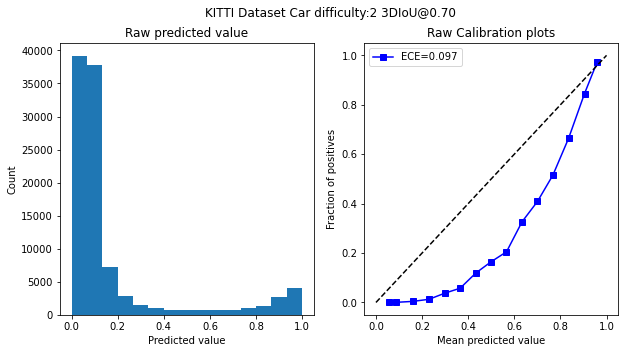

In [7]:
def show_calibration(y_true, y_pred, n_bins=15):
    plt.figure(figsize=(10, 5))
    plt.suptitle("KITTI Dataset Car difficulty:2 3DIoU@0.70")
    plt.subplot(1,2,1)
    plt.title("Raw predicted value")
    plt.hist(y_pred, range=(0, 1), bins=n_bins)
    plt.xlabel("Predicted value")
    plt.ylabel("Count")
    
    plt.subplot(1,2,2)
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins)
    ece = expected_calibration_error(y_true, y_pred, n_bins=n_bins)
    plt.title("Raw Calibration plots")
    plt.plot(prob_pred, prob_true, "bs-", label="ECE=%.3f"%ece)
    plt.xlim(-0.05, 1.05)
    plt.xlabel("Mean predicted value")
    plt.ylabel("Fraction of positives")
    plt.legend()
    
    plt.plot([0,1], [0,1], "k--")
    plt.show()

show_calibration(y_true, y_pred)

This is over-confident.

### Calibration

3-fold CVによってProbabilistic Calibrationを施し、Out-of-Foldでの性能を比較する

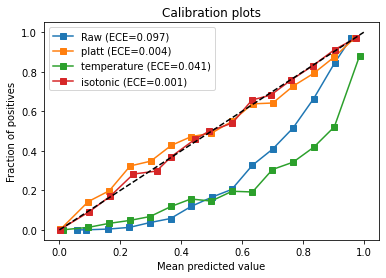

In [8]:
CV = 3

models = {
    "platt": LogisticRegression(random_state=0),
    "temperature": LogisticRegression(random_state=0, fit_intercept=False),
    "isotonic": IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip"),
}
calibed_pred = {
    "platt": [],
    "temperature": [],
    "isotonic": [],
}
calibed_true = []

kf = KFold(CV, shuffle=False)
X = np.array([logit(x) for x in y_pred_li], dtype=object)
y = np.array(y_true_li, dtype=object)
for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = np.concatenate(X[train_idx]).reshape(-1,1), np.concatenate(X[val_idx]).reshape(-1,1)
    y_train, y_val = np.concatenate(y[train_idx]), np.concatenate(y[val_idx])
    calibed_true.append(y_val)
    for key, m in models.items():
        if key == "isotonic":
            inst = m.fit(expit(X_train), y_train)
            calibed_pred[key].append(inst.predict(expit(X_val)))
        else:
            inst = m.fit(X_train, y_train)
            calibed_pred[key].append(inst.predict_proba(X_val)[:,1])

calibed_true = np.concatenate(calibed_true)
calibed_pred = {key: np.concatenate(value) for key, value in calibed_pred.items()}

# show
plt.title("Calibration plots")
prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=15)
ece = expected_calibration_error(y_true, y_pred, n_bins=15)
plt.plot(prob_pred, prob_true, "s-", label="Raw (ECE=%.3f)"%ece)

for key, value in calibed_pred.items():
    prob_true, prob_pred = calibration_curve(calibed_true, value, n_bins=15)
    ece = expected_calibration_error(calibed_true, value, n_bins=15)
    plt.plot(prob_pred, prob_true, "s-", label="%s (ECE=%.3f)"%(key,ece))

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()

plt.plot([0,1], [0,1], "k--")
plt.show()

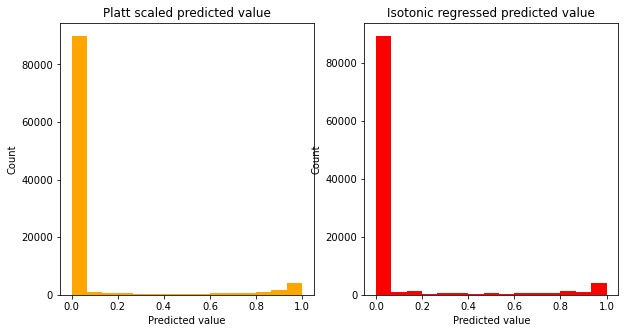

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("Platt scaled predicted value")
plt.hist(calibed_pred["platt"], range=(0, 1), bins=15, color="orange")
plt.xlabel("Predicted value")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.title("Isotonic regressed predicted value")
plt.hist(calibed_pred["isotonic"], range=(0, 1), bins=15, color="red")
plt.xlabel("Predicted value")
plt.ylabel("Count")

plt.show()

In [10]:
df = pd.DataFrame({
    "method": ["(Raw)", "Platt scaling", "IsotonicRegression"],
    "ECE": [expected_calibration_error(y_true, y_pred, 15), expected_calibration_error(calibed_true, calibed_pred["platt"], 15), expected_calibration_error(calibed_true, calibed_pred["isotonic"], 15)],
})

df.set_index("method")

,ECE
method,
(Raw),0.096762
Platt scaling,0.003710
IsotonicRegression,0.001080


# Build A Calibrated Model

In [11]:
# method: Platt scaling

weight = torch.load(MODEL_WEIGHT)
weight.keys()

odict_keys(['global_step', 'voxel_feature_extractor.pfn_layers.0.linear.weight', 'voxel_feature_extractor.pfn_layers.0.norm.weight', 'voxel_feature_extractor.pfn_layers.0.norm.bias', 'voxel_feature_extractor.pfn_layers.0.norm.running_mean', 'voxel_feature_extractor.pfn_layers.0.norm.running_var', 'voxel_feature_extractor.pfn_layers.0.norm.num_batches_tracked', 'rpn.blocks.0.1.weight', 'rpn.blocks.0.2.weight', 'rpn.blocks.0.2.bias', 'rpn.blocks.0.2.running_mean', 'rpn.blocks.0.2.running_var', 'rpn.blocks.0.2.num_batches_tracked', 'rpn.blocks.0.4.weight', 'rpn.blocks.0.5.weight', 'rpn.blocks.0.5.bias', 'rpn.blocks.0.5.running_mean', 'rpn.blocks.0.5.running_var', 'rpn.blocks.0.5.num_batches_tracked', 'rpn.blocks.0.7.weight', 'rpn.blocks.0.8.weight', 'rpn.blocks.0.8.bias', 'rpn.blocks.0.8.running_mean', 'rpn.blocks.0.8.running_var', 'rpn.blocks.0.8.num_batches_tracked', 'rpn.blocks.0.10.weight', 'rpn.blocks.0.11.weight', 'rpn.blocks.0.11.bias', 'rpn.blocks.0.11.running_mean', 'rpn.blocks.0

In [12]:
weight["rpn.conv_cls.weight"].shape, weight["rpn.conv_cls.bias"].shape

(torch.Size([2, 384, 1, 1]), torch.Size([2]))

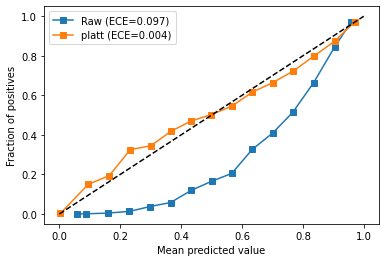

In [13]:
platt = LogisticRegression(random_state=0).fit(logit(y_pred).reshape(-1, 1), y_true)
yc_pred = platt.predict_proba(logit(y_pred).reshape(-1, 1))[:,1]

prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=15)
ece = expected_calibration_error(y_true, y_pred, n_bins=15)
plt.plot(prob_pred, prob_true, "s-", label="Raw (ECE=%.3f)"%ece)

prob_true, prob_pred = calibration_curve(y_true, yc_pred, n_bins=15)
ece = expected_calibration_error(y_true, yc_pred, n_bins=15)
plt.plot(prob_pred, prob_true, "s-", label="%s (ECE=%.3f)"%("platt",ece))

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()

plt.plot([0,1], [0,1], "k--")
plt.show()

In [14]:
platt.coef_.item(), platt.intercept_.item()

(1.8141954244091023, -2.0996922642422917)

In [15]:
OUTPUT_DIR = MODEL_DIR / "calibrated"
OUTPUT_DIR.mkdir(exist_ok=True)

weight = torch.load(MODEL_WEIGHT, map_location="cpu")

cW = np.array([1.0, platt.coef_.item()])
cb = np.array([0.0, platt.intercept_.item()])

W = weight["rpn.conv_cls.weight"]
b = weight["rpn.conv_cls.bias"] 

weight["rpn.conv_cls.weight"] = W * cW.reshape(-1,1,1,1)
weight["rpn.conv_cls.bias"] = b * cW + cb

assert weight["rpn.conv_cls.weight"].shape == W.shape
assert weight["rpn.conv_cls.bias"].shape == b.shape

torch.save(weight, OUTPUT_DIR / f"voxelnet-{GSTEP}.tckpt")

In [16]:
(OUTPUT_DIR / "checkpoints.json").write_text("""{
"latest_ckpt": {
  "voxelnet": "voxelnet-%d.tckpt"
},
"all_ckpts": {
  "voxelnet": [
    "voxelnet-%d.tckpt"
  ]
}
}""" % (GSTEP, GSTEP))

126

In [17]:
command = f"docker run --rm -it --gpus all \
		-v /hdd/kitti:/app/data \
		-v $PWD/model:/app/model \
		second.pytorch:latest \
		python ./pytorch/train.py evaluate \
			--config_path=./configs/{CONF} \
			--model_dir=/app/model/{MODEL}/calibrated \
			--measure_time=True \
			--batch_size=1"
!bash -c "{command}"

/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_CUDA_DRIVER=/usr/lib/x86_64-linux-gnu/libcuda.so.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignor

  0%|          | 0/3769 [00:00<?, ?it/s]

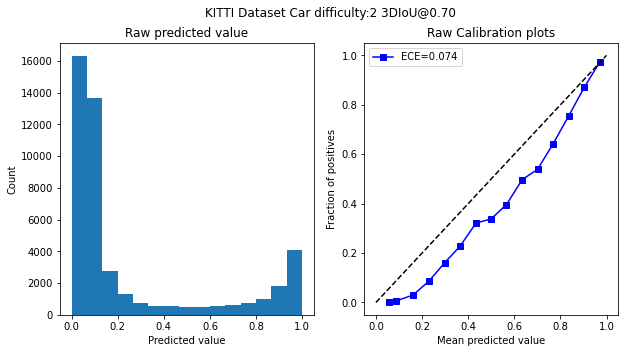

In [18]:
with (OUTPUT_DIR / f"eval_results/step_{GSTEP}/result_kitti.pkl").open("rb") as f:
    dets_calib = pickle.load(f)

cy_true_li = []
cy_pred_li = []

for det in tqdm(dets_calib):
    result = det["official/3d_0.70/2/bin"]
    mask = result != 0 # remove 'ignore' detections
    cy_true_li.append(np.where(result[mask] == 1, 1, 0))
    cy_pred_li.append(det["score"][mask])

cy_true = np.concatenate(cy_true_li)
cy_pred = np.concatenate(cy_pred_li)

show_calibration(cy_true, cy_pred)

In [19]:
import re

with (MODEL_DIR / f"eval_results/step_{GSTEP}/result_evaluation.pkl").open("rb") as f:
    result = pickle.load(f)

with (MODEL_DIR / f"calibrated/eval_results/step_{GSTEP}/result_evaluation.pkl").open("rb") as f:
    result_calib = pickle.load(f)

match = re.search(r"AP:([\d\.]+), ([\d\.]+), ([\d\.]+)", result["official"].split("\n")[3])
match_calib = re.search(r"AP:([\d\.]+), ([\d\.]+), ([\d\.]+)", result_calib["official"].split("\n")[3])

In [20]:
df = pd.DataFrame({
    "method": ["baseline", "Platt scaling"],
    "ECE": [expected_calibration_error(y_true, y_pred, 15), expected_calibration_error(cy_true, cy_pred, 15)],
    "Easy 3DIoU@0.7": [match.group(1), match_calib.group(1)],
    "Moderate 3DIoU@0.7": [match.group(2), match_calib.group(2)],
    "Hard 3DIoU@0.7": [match.group(3), match_calib.group(3)],
})
df.set_index("method")

,ECE,Easy 3DIoU@0.7,Moderate 3DIoU@0.7,Hard 3DIoU@0.7
method,,,,
baseline,0.096762,85.46,76.20,69.98
Platt scaling,0.074233,83.15,75.10,70.65


NMSの前をいじることになるのでECEを再現できない
やはり完全な後処理として実装する必要あり

# Calibration as Postprocessing

In [21]:
with (MODEL_DIR / f"eval_results/step_{GSTEP}/result.pkl").open("rb") as f:
    detections = pickle.load(f)

platt = LogisticRegression(random_state=0).fit(logit(y_pred).reshape(-1, 1), y_true)
for det in detections:
    det["scores"] = torch.Tensor(logit(det["scores"].cpu().numpy()) * platt.coef_.item() + platt.intercept_.item()).sigmoid().to(det["scores"].device)

OUTPUT_POST_DIR = MODEL_DIR / f"calibrated_postprocess/eval_results/step_{GSTEP}"
OUTPUT_POST_DIR.mkdir(exist_ok=True, parents=True)

with (OUTPUT_POST_DIR / "result.pkl").open("wb") as f:
    pickle.dump(detections, f)

In [22]:
command = f"docker run --rm -it --gpus all \
		-v /hdd/kitti:/app/data \
		-v $PWD/model:/app/model \
		second.pytorch:latest \
		python ./pytorch/train.py evaluate_from_result \
			--config_path=./configs/{CONF} \
			--result_path_step=/app/model/{MODEL}/calibrated_postprocess/eval_results/step_{GSTEP} \
			--measure_time=True \
			--batch_size=1"
!bash -c "{command}"

/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_CUDA_DRIVER=/usr/lib/x86_64-linux-gnu/libcuda.so.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignor

  0%|          | 0/3769 [00:00<?, ?it/s]

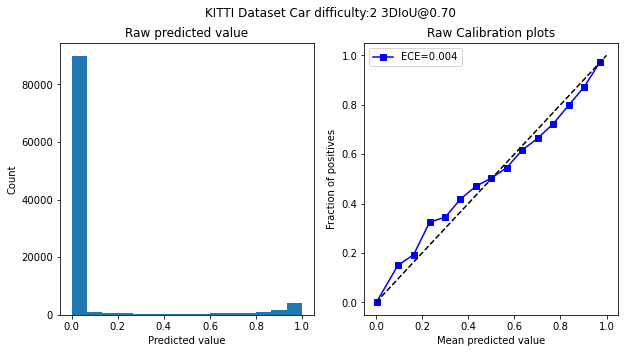

,ECE,Easy 3DIoU@0.7,Moderate 3DIoU@0.7,Hard 3DIoU@0.7
method,,,,
baseline,0.096762,85.46,76.20,69.98
Platt scaling,0.003734,85.46,76.20,69.98


In [23]:
import re

with (MODEL_DIR / f"calibrated_postprocess/eval_results/step_{GSTEP}/result_kitti.pkl").open("rb") as f:
    dets_calib = pickle.load(f)

cy_true_li = []
cy_pred_li = []

for det in tqdm(dets_calib):
    result = det["official/3d_0.70/2/bin"]
    mask = result != 0 # remove 'ignore' detections
    cy_true_li.append(np.where(result[mask] == 1, 1, 0))
    cy_pred_li.append(det["score"][mask])

cy_true = np.concatenate(cy_true_li)
cy_pred = np.concatenate(cy_pred_li)

show_calibration(cy_true, cy_pred)

with (MODEL_DIR / f"eval_results/step_{GSTEP}/result_evaluation.pkl").open("rb") as f:
    result = pickle.load(f)

with (MODEL_DIR / f"calibrated_postprocess/eval_results/step_{GSTEP}/result_evaluation.pkl").open("rb") as f:
    result_calib = pickle.load(f)

match = re.search(r"AP:([\d\.]+), ([\d\.]+), ([\d\.]+)", result["official"].split("\n")[3])
match_calib = re.search(r"AP:([\d\.]+), ([\d\.]+), ([\d\.]+)", result_calib["official"].split("\n")[3])

df = pd.DataFrame({
    "method": ["baseline", "Platt scaling"],
    "ECE": [expected_calibration_error(y_true, y_pred, 15), expected_calibration_error(cy_true, cy_pred, 15)],
    "Easy 3DIoU@0.7": [match.group(1), match_calib.group(1)],
    "Moderate 3DIoU@0.7": [match.group(2), match_calib.group(2)],
    "Hard 3DIoU@0.7": [match.group(3), match_calib.group(3)],
})
df.set_index("method")